# Text Preprocessing

In [1]:
%matplotlib inline

In [23]:
# Fix a spacy-Jupyter bug
# https://github.com/jupyter/notebook/issues/4369#issuecomment-459377498
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [2]:
import gensim as g
import gzip
import itertools as it
import os
import pandas as pd
import spellchecker
import snowballstemmer
import spacy
import stop_words
import re
import unidecode

from concurrent import futures

## Read in the Corpus

I plan to stay away form *gensim*'s inbuilt stuff so that I can have simple, fine control over the details.

In [3]:
corpus_root = '../../data/arxiv/text'

 1. Build up a list of text files
 2. Read each file in as a string

In [4]:
def find_text_files(root):
    for pwd, dirs, files in os.walk(root):
        text_files = filter(lambda f: f.endswith('.txt.gz'), files)
        for f in text_files:
            yield os.path.join(pwd, f)

In [5]:
def ingest_text_file(path):
    # Metadata
    archive = os.path.basename(os.path.dirname(path))
    identifier = os.path.basename(path).rstrip('.txt.gz')
    # Contents
    contents = gzip.GzipFile(path).read().decode()
    return {'id': identifier, 'text': contents}

In [6]:
corpus = [ingest_text_file(p) for p in find_text_files(corpus_root)]

In [7]:
len(corpus)

17750

## Tokenization, Etc.

 - Tokenize each document
 - Combine as in R's *tidytext*

In [8]:
def tokenize(doc, disable_hyphen_split=False):
    # split on whitespace and remove empty tokens
    stream = filter(None, re.split(r'[\s]+', doc['text']))
    
    # normalize to ascii and convert to lowercase
    stream = [unidecode.unidecode(s).lower() for s in stream]
    
    # collapse commonly-hyphenated words
    HYPHEN_COLLAPSE = {
        r'x-ray': 'xray',
        r'e-mail': 'email',
        r'non-([a-zA-Z])': 'non\\1',
        r'space-time': 'spacetime'
    }
    for k in HYPHEN_COLLAPSE:
        stream = [re.sub(k, HYPHEN_COLLAPSE[k], s) for s in stream]
    
    # Remove bracket detritus like blah[blah]
    stream = [s for s in stream if re.search(r'[^\[\]]+[[^\[\]]+', s) is None]
    
    # Deeper split: hyphens, slashes, parens, braces, etc.
    # This throws away some technical information [e.g.: the "so(n)" lie algebra] but helps w/words
    if not disable_hyphen_split:
        # https://stackoverflow.com/a/952952/656740
        stream = filter(None, it.chain.from_iterable(re.split(r'[-/\\(){}–—,]+', s) for s in stream))
    
    # remove common LaTeX labels like fig:blah or eq:blah1
    stream = [s for s in stream if re.search(r'(fig|eqn?)[:a-zA-Z0-9]', s) is None]
    
    # strip edge punctuation
    stream = [re.sub(r'(?<=^)[^a-zA-Z0-9]+|[^a-zA-Z0-9]+(?=$)', '', s) for s in stream]
    
    # do not include nonword tokens
    stream = filter(lambda s: re.search(r'[a-zA-Z]', s), stream)
    
    # remove email addresses
    stream = [s for s in stream if s.find('@') == -1]
    
    # strip possession
    stream = [re.sub(r"'s$", '', s) for s in stream]
    
    # remove leftover colon-y things like 'sec:my_great_section'
    stream = [s for s in stream if s.find(':') == -1]
    
    # Add to dictionary
    tokens = {}
    for tkn in stream:
        if tkn not in tokens:
            tokens[tkn] = 0
        tokens[tkn] += 1
    
    return pd.DataFrame([
        {'doc': doc['id'], 'token': token, 'count': tokens[token]}
        for token in tokens
    ])

In [9]:
%%time

jobs = []
with futures.ProcessPoolExecutor() as fexec:
    for doc in corpus:
        jobs += [fexec.submit(tokenize, doc, disable_hyphen_split=False)]
    futures.wait(jobs)
tokens = pd.concat([job.result() for job in jobs])

CPU times: user 32.6 s, sys: 4.09 s, total: 36.6 s
Wall time: 5min 59s


This gives us a table with documents by tokens by counts.

In [ ]:
tokens.head()

We can also quickly aggregate to get per-token counts:

In [11]:
token_counts = tokens.groupby('token').agg('sum').reset_index().sort_values('count', ascending=False)

In [24]:
token_counts.head()

token    count
377083   the  7152559
269730    of  3400450
34013    and  2359157
177662    in  2113193
20803      a  1933270

Or, to the number of documents containing a given token:

In [25]:
token_doc_counts = tokens.groupby('token')['doc'].nunique().to_frame().reset_index()

In [26]:
token_doc_counts.sort_values('doc', ascending=False).head(n=25)

token    doc
269730     of  17608
34013     and  17597
377083    the  17584
137810    for  17533
177662     in  17530
20803       a  17529
380746     to  17467
66843      by  17452
408142   with  17426
271384     on  17397
184079     is  17396
378594   this  17396
39173     are  17364
40506      as  17334
377002   that  17331
51167      be  17301
140546   from  17295
33475      an  17222
406346  which  17140
185183     it  17132
162758   have  17076
404607     we  17059
69745     can  17002
42127      at  16976
265650    not  16887

## Spelling Normalization

Some part of the spelling normalization has already happened, if only because we have destroyed hyphenated words. As above, we need to balance "getting things right" with practicality. We probably ought not to fix words appearing in very few documents.

In [27]:
checker = spellchecker.SpellChecker(language='en', distance=2)

How many words have how many counts?

In [28]:
print('Thresh: Tokens')
for threshold_ten in range(1, 6):
    print(f'{10**threshold_ten:>6d}: {token_counts[token_counts["count"] > 10**threshold_ten].shape[0]:>6d}')

Thresh: Tokens
    10:  71978
   100:  18758
  1000:   5100
 10000:   1069
100000:     79


In [29]:
for token in checker.unknown(token_counts[token_counts['count'] > 5000].sort_values('count', ascending=False)['token'].values):
    counts = token_counts[token_counts['token'] == token]['count'].values[0]
    candidate = checker.correction(token)
    if candidate == token or candidate.startswith('non-'):
        continue
    print(f'({counts}): {token} => {candidate}')

(9073): abelian => belgian
(7751): jhep => jeep
(6688): appl => apply
(6889): functor => function
(6763): homotopy => homology
(7842): 2d => d
(7631): cohomology => homology
(8393): affine => affines
(8850): morphism => orphism
(11526): http => ttp
(5467): supersymmetric => persymmetric
(15680): nucl => null
(5005): tev => ten
(5312): lepton => leyton
(8036): fermions => versions
(5708): banach => branch
(8922): fermion => version
(6679): 3d => d
(21661): cannot => cannon
(5970): agn => an
(5427): integrable => integrale
(5113): phonon => photon
(6987): mnras => mrnas
(6466): fiber => fibre
(8222): resp => rest
(7421): holomorphic => polymorphic
(8783): brane => brave
(6943): qubit => quit
(9447): subspace => sub-space
(17647): xray => ray
(11286): conformal => informal
(5385): bosons => bosoms
(7342): adjoint => adjoins
(5701): perturbative => perturbation
(5824): branes => barnes
(14470): apj => apt
(5641): graphene => grapheme
(11111): qcd => cd


Fortunately, these papers contain reasonably strong spelling. The suggestions are mostly wrong.

## Word Statistics

Number of documents that words appear in:

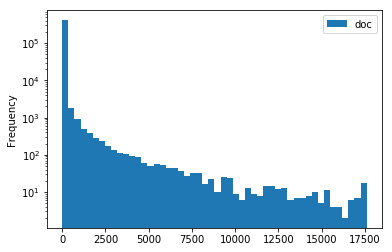

In [30]:
token_doc_counts.plot.hist('doc', log=True, bins=50)

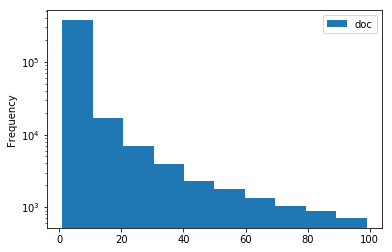

In [31]:
token_doc_counts[token_doc_counts.doc < 100].plot.hist('doc', log=True)

In [32]:
token_doc_counts[token_doc_counts.doc <= 5].sort_values('doc', ascending=False).head()

token  doc
186211     j.ashman    5
220181  lipperheide    5
317023     resonace    5
144933      galleti    5
24781      abrashev    5

## Stemming or Lemmatizing

Given our time constraints, let's try to use the Porter stemming algorithm rather than muck around with model-based lemmatization.

In [33]:
stemmer = snowballstemmer.EnglishStemmer()

In [34]:
token_counts['stem'] = stemmer.stemWords(token_counts['token'].values)

In [35]:
token_counts[token_counts['stem'] != token_counts['token']].head(n=20)

token   count     stem
271658       only  149055     onli
121175     energy  133357   energi
348189      since  130686     sinc
392992      using  123381      use
36353         any  117503      ani
137535  following  107731   follow
317492    results  106776   result
185418        its   99847       it
377650     theory   93460   theori
105637  different   87046   differ
100098    defined   81643    defin
170657    however   81138    howev
137545    follows   81073   follow
24701       above   79931     abov
102090    density   79901  densiti
213771      large   79545     larg
392886       used   79343      use
395490      value   77895     valu
86497    consider   76667   consid
395519     values   73870     valu

Now, we would typically collapse the list and map the most common work to each stem.

In [36]:
stem_sums = token_counts.groupby('stem')['count'].agg('sum').to_frame()
stem_first = token_counts.groupby('stem')['token'].first().to_frame()
token_counts = stem_first.join(stem_sums).reset_index().sort_values('count', ascending=False)

In [37]:
token_counts.head(n=20)

stem token    count
333521   the   the  7152559
239792    of    of  3400456
32287    and   and  2359164
157113    in    in  2113514
20771      a     a  1933270
161713    is    is  1867438
336809    to    to  1646143
121036   for   for  1216244
357638    we    we  1108558
333449  that  that  1105427
360826  with  with   772823
61403     by    by   755063
47305     be    be   632329
36646    are   are   627795
37798     as    as   625766
334868  this  this   623863
241300    on    on   525218
162608    it    it   454984
123407  from  from   418396
39098     at    at   380063

## Stopwords

In [227]:
# Default English stuff
default_stop_list = stop_words.get_stop_words('en')
default_stop_list[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [39]:
stopped_tokens = token_counts[~token_counts['stem'].isin(default_stop_list)]
stopped_tokens = stopped_tokens[~stopped_tokens['token'].isin(default_stop_list)]

In [40]:
stopped_tokens.head()

stem     token   count
64112        can       can  342936
346865       use     using  297589
241395       one       one  263434
124445  function  function  235827
217572     model     model  211206

In [41]:
# Remove numbers
stopwords = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'}
stopped_tokens = stopped_tokens[~stopped_tokens['token'].isin(stopwords)]
stopped_tokens = stopped_tokens[~stopped_tokens['token'].apply(lambda f: re.search(r'[a-zA-Z]', f) is None)]

In [42]:
# Remove one-char tokens
stopped_tokens = stopped_tokens[stopped_tokens['token'].apply(len) > 1]

In [43]:
# Remove single-occurrence tokens
stopped_tokens = stopped_tokens[stopped_tokens['count'] > 1]

In [44]:
# Remove single-document tokens
stopped_tokens = stopped_tokens[stopped_tokens['token'].isin(token_doc_counts['token'][token_doc_counts['doc'] > 1])]

In [46]:
#stopped_tokens.head(n=50)

In [47]:
# top 50 remaining
stop_keep = {
    'function', 'model', 'state', 'field', 'time', 'order', 'energi', 'point', 'system',
    'observ', 'space', 'relat', 'mass', 'measur', 'theori', 'effect', 'paramet', 'oper',
    'general'
}

stopwords = set(stopped_tokens['stem'].head(50).values).difference(stop_keep)
stopped_tokens = stopped_tokens[~stopped_tokens['stem'].isin(stopwords)]

In [48]:
# A few more ot be rid of in the top-100
stopped_tokens = stopped_tokens[~ stopped_tokens['stem'].isin({'rev', 'fig', 'et.al', 'et', 'al', 'i.e'})]

In [ ]:
stopped_tokens.shape

We got the token count down to around 128K. We're in a place to implement in the cloud and develop a full corpus and dictionary.

## Using *spacy*

The *spacy* NLP library has a pretty good model-based tokenizer and lemmatizer. Let's build a second tokenization pipeline on top of this package. See *Spacy Experiments.ipynb* for some unorganized exploration of *spacy* that leads to these parameters.

In [161]:
# Need the tagger to correctly lemmatize tokens
nlp = spacy.load('en', disable=['ner', 'parser'])

In [222]:
def tokenize_spacy(document):
    # Normalize uncicode strings
    text = g.corpora.textcorpus.deaccent(document['text'])
    
    # Pre-collapse known hyphenated strings
    RE_HYPHEN_COLLAPSE = [
        {'search': re.compile(r'x[-—]ray'),                       'replace': 'xray'},
        {'search': re.compile(r'e[-—]mail'),                      'replace': 'email'},
        {'search': re.compile(r'non[-—]([a-zA-Z])'),              'replace': 'non\\1'},
        {'search': re.compile(r'space[-—]time'),                  'replace': 'spacetime'},
        {'search': re.compile(r'((?<!\w)[-–—]+)|([-–—]+(?!\w))'), 'replace': ''}
    ]
    for regex in RE_HYPHEN_COLLAPSE:
        text = regex['search'].sub(regex['replace'], text)
    
    # Process with spacy
    doc = nlp(text)
    
    
    # Return
    RE_WORD = re.compile(r'[\w]')
    RE_BRACES = re.compile(r'[\[\](){}]')
    RE_NUMBERS = re.compile(r'^[0-9\.–—,+-]+$')
    RE_EMAIL = re.compile(r'[@]')
    RE_ENVS = re.compile(r'(?<=\b)(ref(erence)?|fig(ure)?|eq(uatio)?n?|th(eore)?m|lem(ma)?|ta?bl?e?)(?=\b)')

    return pd.DataFrame([
        {
            'doc': document['id'], 
            'token': t.text,
            'lemma': t.lemma_,
            'count': 1
        }
        for t in doc
        if t.lemma_ != '-PRON-'
        and RE_WORD.search(t.lemma_) is not None
        and RE_BRACES.search(t.lemma_) is None
        and RE_NUMBERS.search(t.lemma_) is None
        and RE_EMAIL.search(t.lemma_) is None
        and RE_ENVS.search(t.lemma_) is None
    ])

In [223]:
%%time

# Fewer docs because spacy takes so long
jobs = []
with futures.ProcessPoolExecutor() as fexec:
    for doc in corpus[:5000]:
        jobs += [fexec.submit(tokenize_spacy, doc)]
    futures.wait(jobs)
spacy_tokens = pd.concat([job.result() for job in jobs])

CPU times: user 23.4 s, sys: 10.6 s, total: 34 s
Wall time: 20min 41s


In [224]:
spacy_token_counts = (
    spacy_tokens.groupby('lemma')['count']
                .agg(sum)
                .to_frame()
                .reset_index()
                .sort_values('count', ascending=False)
)

In [226]:
spacy_token_counts.head(n=20)

lemma    count
232297    the  2091673
170014     of  1012212
39341      be  1002877
21550     and   721796
119159     in   628101
14521       a   545440
234578     to   487516
92801     for   375014
232273   that   345718
251214   with   235450
48233      by   231776
33023      as   191104
233180   this   180240
170969     on   162368
107377   have   152025
94614    from   123869
21227      an   111151
49773     can   111031
34079      at   108166
250198  which   104146

In [203]:
# Brackets: these can go away
# spacy_token_counts[
#     spacy_token_counts['lemma'].apply(lambda t: re.search(r'[\[\](){}]', t) is not None)
# ]

In [204]:
# Hyphens: strip pre- and post-hyphens
# spacy_token_counts[
#     spacy_token_counts['lemma'].apply(lambda t: re.search(r'(?<!^)[-]', t) is not None)
# ]

In [205]:
# Punctuation: fine as-is
# spacy_token_counts[
#     spacy_token_counts['lemma'].apply(lambda t: re.search(r'[,\.–—;-]', t) is not None)
# ].head(n=20)

In [206]:
# Numbers: these can go
# spacy_token_counts[
#     spacy_token_counts['lemma'].apply(lambda t: re.search(r'^[0-9\.–—,+-]+$', t) is not None)
# ].head(n=35)

In [220]:
# Latex environments: begone
# spacy_token_counts[
#     spacy_token_counts['lemma'].apply(lambda t: re.search(r'(?<=\b)(ref(erence)?|fig(ure)?|eq(uatio)?n?|th(eore)?m|lem(ma)?|ta?bl?e?)(?=\b)', t) is not None)
# ]

### Stop Words

In [232]:
spacy_token_counts[~spacy_token_counts['lemma'].isin(default_stop_list)][:50]

lemma   count
49773         can  111031
242100        use   88185
171018        one   74136
95344    function   67344
139593        let   65512
100653       give   63782
213956       show   63538
155483      model   61283
238461        two   60758
198368     result   60347
50784        case   59298
92645      follow   57739
20514        also   53790
212163        set   52166
210733        see   51890
221529      state   49791
233961       time   48397
244010      value   48009
68285      define   46859
89460       field   46139
124169         j.   44696
183996      point   44508
171994      order   42498
227545     system   42049
250770       will   41896
169544     obtain   41170
215443      since   40834
81236      energy   39922
168389     number   39237
91291       first   38445
218623      space   38268
209985    section   38218
60155    consider   38020
181745       phys   37191
14578          a.   36349
144527         m.   35885
230589       term   35525
92976        form   34653
137263      large   34316
175788  parameter   31612
217971   solution   29948
233618       thus   29832
90976        find   29472
59431   condition   28984
148380       mass   28114
109564       high   28012
216686      small   27506
149975        may   27501
33557      assume   27400
140959       line   27370